# Multi-Momentum PID Analysis: XGBoost + Deep Neural Network Ensemble
## Particle Identification with Optuna, Model Caching & Ensemble Methods

This notebook implements an **ensemble approach** combining:
- **XGBoost**: Traditional gradient boosting for feature importance and sharp boundaries
- **Deep Neural Networks (DNN)**: Deep learning for complex feature interactions
- **Ensemble Voting**: Combines both models for optimal performance


In [ ]:
!pip install hipe4ml optuna pandas numpy matplotlib seaborn scikit-learn xgboost ipywidgets tensorflow keras -q
!pip install scikit-learn>=1.6 -q
print("✓ Dependencies installed")

✓ Dependencies installed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pickle
import os
import json

from hipe4ml.model_handler import ModelHandler
from hipe4ml import plot_utils

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
import ipywidgets as widgets
from IPython.display import display, clear_output

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## SECTION 1: Configuration
### Define Momentum Ranges, Particles & Storage Paths

In [ ]:
print("="*80)
print("SECTION 1: CONFIGURATION")
print("="*80)

drive.mount('/content/drive')

MOMENTUM_RANGES = {
    'full': {'name': 'All Data (full spectrum)', 'min': 0.0,  'max': 999, 'color': '#9333EA'},
    'low':  {'name': '0.1-1 GeV/c',           'min': 0.1, 'max': 1.0,  'color': '#3B82F6'},
    'mid':  {'name': '1-3 GeV/c',            'min': 1.0, 'max': 3.0,  'color': '#F59E0B'},
    'high': {'name': '3+ GeV/c',             'min': 3.0, 'max': 999,  'color': '#22C55E'}
}

PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']

# Storage directories
BASE_DIR = '/content/drive/MyDrive/PID_Models/'
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'XGBoost/')
DNN_SAVE_DIR = os.path.join(BASE_DIR, 'DNN/')
OPTUNA_SAVE_DIR = os.path.join(BASE_DIR, 'Optuna_Studies/')
ENSEMBLE_SAVE_DIR = os.path.join(BASE_DIR, 'Ensemble/')

for directory in [MODEL_SAVE_DIR, DNN_SAVE_DIR, OPTUNA_SAVE_DIR, ENSEMBLE_SAVE_DIR]:
    os.makedirs(directory, exist_ok=True)

print("✓ Configuration loaded")
print(f"  Momentum ranges: {list(MOMENTUM_RANGES.keys())}")
print(f"  Base storage: {BASE_DIR}")

SECTION 1: CONFIGURATION
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Configuration loaded
  Momentum ranges: ['full', 'low', 'mid', 'high']
  Base storage: /content/drive/MyDrive/PID_Models/


### Save/Load Functions for XGBoost, DNN & Optuna Studies

In [ ]:
# XGBOOST SAVE/LOAD
def save_xgboost_model(range_key, model_info, dataset_info):
    save_path = os.path.join(MODEL_SAVE_DIR, f'xgb_model_{range_key}.pkl')
    save_data = {
        'model': model_info['model_handler'].model,
        'features': available_features,
        'config': model_info['config'],
        'train_acc': model_info['train_acc'],
        'test_acc': model_info['test_acc'],
        'train_auc': model_info.get('train_auc', 0),
        'test_auc': model_info.get('test_auc', 0),
        'n_train': dataset_info['n_train'],
        'n_test': dataset_info['n_test']
    }
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"   Saved XGBoost model: {save_path}")

def load_xgboost_model(range_key):
    load_path = os.path.join(MODEL_SAVE_DIR, f'xgb_model_{range_key}.pkl')
    if not os.path.exists(load_path):
        return None
    with open(load_path, 'rb') as f:
        save_data = pickle.load(f)
    model_hdl = ModelHandler(save_data['model'], save_data['features'])
    model_hdl.model = save_data['model']
    return {
        'model_handler': model_hdl,
        'config': save_data['config'],
        'train_acc': save_data['train_acc'],
        'test_acc': save_data['test_acc'],
        'train_auc': save_data.get('train_auc', 0),
        'test_auc': save_data.get('test_auc', 0)
    }

# DNN SAVE/LOAD
def save_dnn_model(range_key, dnn_model, scaler, metrics_dict):
    model_path = os.path.join(DNN_SAVE_DIR, f'dnn_model_{range_key}.keras')
    dnn_model.save(model_path)

    # Save scaler and metrics
    scaler_path = os.path.join(DNN_SAVE_DIR, f'dnn_scaler_{range_key}.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    metrics_path = os.path.join(DNN_SAVE_DIR, f'dnn_metrics_{range_key}.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics_dict, f)

    print(f"   Saved DNN model: {model_path}")

def load_dnn_model(range_key):
    model_path = os.path.join(DNN_SAVE_DIR, f'dnn_model_{range_key}.keras')
    if not os.path.exists(model_path):
        return None

    dnn_model = keras.models.load_model(model_path)

    scaler_path = os.path.join(DNN_SAVE_DIR, f'dnn_scaler_{range_key}.pkl')
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    metrics_path = os.path.join(DNN_SAVE_DIR, f'dnn_metrics_{range_key}.json')
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    return {'model': dnn_model, 'scaler': scaler, 'metrics': metrics}

# OPTUNA SAVE/LOAD
def save_optuna_study(range_key, study):
    save_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved Optuna study: {save_path}")

def load_optuna_study(range_key):
    load_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_{range_key}.pkl')
    if not os.path.exists(load_path):
        return None
    with open(load_path, 'rb') as f:
        study = pickle.load(f)
    return study

def check_saved_models():
    xgb_models = [
        f.replace('xgb_model_', '').replace('.pkl', '')
        for f in os.listdir(MODEL_SAVE_DIR)
        if f.startswith('xgb_model_') and f.endswith(".pkl")
    ]
    dnn_models = [
        f.replace('dnn_model_', '').replace('.keras', '')
        for f in os.listdir(DNN_SAVE_DIR)
        if f.startswith('dnn_model_') and f.endswith('.keras')
    ]
    return {'xgb': xgb_models, 'dnn': dnn_models}

print("✓ Save/Load functions defined")

✓ Save/Load functions defined


## SECTION 2: Data Loading & Cleaning
### Load CSV & Prepare Features

In [ ]:
print("\n" + "="*80)
print("SECTION 2: DATA LOADING & CLEANING")
print("="*80)

csv_file_path = '/content/drive/MyDrive/pid_features_large.csv'
df_iter = pd.read_csv(csv_file_path, dtype='float32', chunksize=500_000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)
print(f"✓ Loaded: {df.shape}")

# Clean data
df.replace(-999, np.nan, inplace=True)
tof_features = [col for col in df.columns if 'tof' in col.lower()]
tpc_features = [col for col in df.columns if 'tpc' in col.lower()]
df[tof_features] = df[tof_features].fillna(0)
df[tpc_features] = df[tpc_features].fillna(0)
df['has_tof'] = (df[tof_features].abs().sum(axis=1) > 0).astype(int)
df['has_tpc'] = (df[tpc_features].abs().sum(axis=1) > 0).astype(int)
df.dropna(subset=['pt', 'eta', 'mc_pdg'], inplace=True)
print(f"✓ Cleaned: {df.shape}")

# PDG mapping
def pdg_to_species(pdg):
    ap = abs(int(pdg))
    if ap == 211:          return 0
    elif ap == 321:        return 1
    elif ap == 2212:       return 2
    elif ap == 11:         return 3
    # elif ap == 1000010020: return 4
    else: return -1

df['particle_species'] = df['mc_pdg'].apply(pdg_to_species)
df = df[df['particle_species'] >= 0].reset_index(drop=True)

# Feature engineering
for feature in ['pt', 'p', 'tpc_signal', 'tof_beta']:
    if feature in df.columns:
        df[feature] = np.log1p(df[feature].abs())

training_features = [
    'pt', 'eta', 'phi',
    'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
    'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
    'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
    'dca_xy', 'dca_z', 'has_tpc', 'has_tof'
]
available_features = [f for f in training_features if f in df.columns]
print(f"✓ Features: {len(available_features)}")


SECTION 2: DATA LOADING & CLEANING
✓ Loaded: (4729393, 37)
✓ Cleaned: (4729392, 37)
✓ Features: 21


## SECTION 3: Momentum Range Splitting
### Prepare 4 Independent Datasets

In [ ]:
print("\n" + "="*80)
print("SECTION 3: MOMENTUM RANGE SPLITTING")
print("="*80)

momentum_datasets = {}

for range_key, range_config in MOMENTUM_RANGES.items():
    print(f"\n{range_config['name']}")
    df_range = df[(df['pt'] >= range_config['min']) & (df['pt'] < range_config['max'])].copy()
    print(f"   Tracks: {len(df_range):,}")

    if len(df_range) == 0 or df_range['particle_species'].value_counts().min() < 10:
        continue

    X = df_range[available_features].astype('float32')
    y = df_range['particle_species']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=available_features).astype('float32')

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = pd.Series(y_train.values), pd.Series(y_test.values)

    momentum_datasets[range_key] = {
        'config': range_config,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'scaler': scaler,
        'n_train': len(X_train), 'n_test': len(X_test)
    }
    print(f"   Train: {len(X_train):,}, Test: {len(X_test):,}")

print(f"\n✓ Prepared {len(momentum_datasets)} ranges")


SECTION 3: MOMENTUM RANGE SPLITTING

All Data (full spectrum)
   Tracks: 4,163,954
   Train: 2,914,767, Test: 1,249,187

0.1-1 GeV/c
   Tracks: 3,956,919
   Train: 2,769,843, Test: 1,187,076

1-3 GeV/c
   Tracks: 128,035
   Train: 89,624, Test: 38,411

3+ GeV/c
   Tracks: 157
   Train: 109, Test: 48

✓ Prepared 4 ranges


## SECTION 4: Optuna Hyperparameter Optimisation
### Optimise XGBoost Parameters (with Auto-Load & Save)

In [ ]:
print("\n" + "="*80)
print("SECTION 4: OPTUNA OPTIMISATION FOR XGBOOST")
print("="*80)

optuna_studies_xgb = {}
FORCE_REOPTIMIZE_XGB = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing XGBoost Optuna: {config['name']}")

    # Try to load
    study_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_xgb_{range_key}.pkl')
    if os.path.exists(study_path) and not FORCE_REOPTIMIZE_XGB:
        print(f"Loading saved XGBoost study...")
        with open(study_path, 'rb') as f:
            study = pickle.load(f)
        optuna_studies_xgb[range_key] = study
        print(f"   Best ROC-AUC: {study.best_value:.4f}")
        continue

    # Optimise
    print(f"Running XGBoost optimisation...")
    X_train_optuna = dataset['X_train'].sample(min(300_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0)
        }
        model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1, tree_method='hist')
        model.fit(X_train_optuna, y_train_optuna)
        y_pred = model.predict_proba(dataset['X_test'])
        return roc_auc_score(dataset['y_test'], y_pred, multi_class='ovo', average='weighted')

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    optuna_studies_xgb[range_key] = study

    # Save with xgb_ prefix
    save_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_xgb_{range_key}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved study to: {save_path}")
    print(f"   Best ROC-AUC: {study.best_value:.4f}")

print("\nOptuna XGBoost optimisation complete")



SECTION 4: OPTUNA OPTIMISATION FOR XGBOOST

Processing XGBoost Optuna: All Data (full spectrum)
Loading saved XGBoost study...
   Best ROC-AUC: 0.9384

Processing XGBoost Optuna: 0.1-1 GeV/c
Loading saved XGBoost study...
   Best ROC-AUC: 0.9410

Processing XGBoost Optuna: 1-3 GeV/c
Loading saved XGBoost study...
   Best ROC-AUC: 0.8430

Processing XGBoost Optuna: 3+ GeV/c
Loading saved XGBoost study...
   Best ROC-AUC: 0.6954

Optuna XGBoost optimisation complete


## SECTION 4B: Optuna Hyperparameter Optimisation for DNN
### Optimise Neural Network Architecture & Hyperparameters (with Auto-Load & Save)

In [ ]:
print("\n" + "="*80)
print("SECTION 4B: OPTUNA OPTIMISATION FOR DNN")
print("="*80)

optuna_studies_dnn = {}
FORCE_REOPTIMIZE_DNN = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing DNN Optuna: {config['name']}")

    # Try to load
    study_path = os.path.join(OPTUNA_SAVE_DIR, f'optuna_study_dnn_{range_key}.pkl')
    if os.path.exists(study_path) and not FORCE_REOPTIMIZE_DNN:
        print(f"Loading saved DNN study...")
        with open(study_path, 'rb') as f:
            study = pickle.load(f)
        optuna_studies_dnn[range_key] = study
        print(f"   Best validation accuracy: {study.best_value:.4f}")
        continue

    # Optimise
    print(f"Running DNN optimisation...")

    # Sample subset for faster optimisation
    X_train_optuna = dataset['X_train'].sample(min(200_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    # Validation split for Optuna
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_optuna, y_train_optuna, test_size=0.2, random_state=42, stratify=y_train_optuna
    )

    def objective_dnn(trial):
        # Suggest hyperparameters
        n_layers = trial.suggest_int('n_layers', 2, 4)
        units_layer_1 = trial.suggest_categorical('units_layer_1', [128, 256, 512])
        units_layer_2 = trial.suggest_categorical('units_layer_2', [64, 128, 256])
        units_layer_3 = trial.suggest_categorical('units_layer_3', [32, 64, 128])
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
        l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)

        # Build model
        model = keras.Sequential()
        model.add(layers.Input(shape=(len(available_features),)))

        # First layer
        model.add(layers.Dense(units_layer_1, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

        # Second layer
        model.add(layers.Dense(units_layer_2, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

        # Optional third and fourth layers
        if n_layers >= 3:
            model.add(layers.Dense(units_layer_3, activation='relu',
                                  kernel_regularizer=regularizers.l2(l2_reg)))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(dropout_rate * 0.7))

        if n_layers >= 4:
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dropout(dropout_rate * 0.5))

        # Output layer
        model.add(layers.Dense(len(PARTICLE_NAMES), activation='softmax'))

        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train with early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_tr.values, y_tr.values,
            validation_data=(X_val.values, y_val.values),
            batch_size=batch_size,
            epochs=30,
            callbacks=[early_stop],
            verbose=0
        )

        # Return best validation accuracy
        val_acc = max(history.history['val_accuracy'])
        return val_acc

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective_dnn, n_trials=20, show_progress_bar=True)
    optuna_studies_dnn[range_key] = study

    # Save study
    with open(study_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved study to: {study_path}")
    print(f"   Best validation accuracy: {study.best_value:.4f}")
    print(f"   Best parameters: {study.best_params}")

print("\nOptuna DNN optimisation complete")


SECTION 4B: OPTUNA OPTIMISATION FOR DNN

Processing DNN Optuna: All Data (full spectrum)
Loading saved DNN study...
   Best validation accuracy: 0.8544

Processing DNN Optuna: 0.1-1 GeV/c
Loading saved DNN study...
   Best validation accuracy: 0.8632

Processing DNN Optuna: 1-3 GeV/c
Loading saved DNN study...
   Best validation accuracy: 0.7336

Processing DNN Optuna: 3+ GeV/c
Loading saved DNN study...
   Best validation accuracy: 0.7273

Optuna DNN optimisation complete


## SECTION 5: XGBoost Model Training
### Train with Auto-Save & Load

In [ ]:
print("\n" + "="*80)
print("SECTION 5: XGBOOST MODEL TRAINING")
print("="*80)

saved_models = check_saved_models()
trained_xgb_models = {}
FORCE_RETRAIN_XGB = False

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"XGBoost: {config['name']}")

    # Try to load
    if range_key in saved_models['xgb'] and not FORCE_RETRAIN_XGB:
        print(f"Loading XGBoost model...")
        loaded = load_xgboost_model(range_key)
        if loaded:
            y_pred = loaded['model_handler'].model.predict_proba(dataset['X_test'])
            trained_xgb_models[range_key] = {
                'model_handler': loaded['model_handler'],
                'y_pred_proba': y_pred,
                'train_acc': loaded['train_acc'],
                'test_acc': loaded['test_acc'],
                'config': config
            }
            print(f"Loaded! Test Acc: {loaded['test_acc']:.4f}")
            continue

    # Train
    print(f"Training XGBoost...")
    best_params = optuna_studies_xgb[range_key].best_params
    model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1, tree_method='hist')
    model.fit(dataset['X_train'], dataset['y_train'])

    y_pred = model.predict_proba(dataset['X_test'])
    train_acc = model.score(dataset['X_train'], dataset['y_train'])
    test_acc = model.score(dataset['X_test'], dataset['y_test'])

    model_hdl = ModelHandler(model, available_features)
    model_hdl.model = model

    trained_xgb_models[range_key] = {
        'model_handler': model_hdl,
        'y_pred_proba': y_pred,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"   Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    save_xgboost_model(range_key, trained_xgb_models[range_key], dataset)

print(f"\nXGBoost training complete")



SECTION 5: XGBOOST MODEL TRAINING

XGBoost: All Data (full spectrum)
Loading XGBoost model...
Loaded! Test Acc: 0.8675

XGBoost: 0.1-1 GeV/c
Loading XGBoost model...
Loaded! Test Acc: 0.8741

XGBoost: 1-3 GeV/c
Loading XGBoost model...
Loaded! Test Acc: 0.7470

XGBoost: 3+ GeV/c
Loading XGBoost model...
Loaded! Test Acc: 0.6667

XGBoost training complete


## SECTION 6: Deep Neural Network Training
### Build & Train DNN Models with Auto-Save & Load

In [ ]:
print("\n" + "="*80)
print("SECTION 6: DEEP NEURAL NETWORK TRAINING")
print("="*80)

trained_dnn_models = {}
FORCE_RETRAIN_DNN = False

def build_dnn_model_from_params(params, input_dim, num_classes):
    """Build DNN architecture from Optuna parameters."""
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Layer 1
    model.add(layers.Dense(params['units_layer_1'], activation='relu',
                          kernel_regularizer=regularizers.l2(params['l2_reg'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['dropout_rate']))

    # Layer 2
    model.add(layers.Dense(params['units_layer_2'], activation='relu',
                          kernel_regularizer=regularizers.l2(params['l2_reg'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['dropout_rate']))

    # Layer 3 (conditional)
    if params['n_layers'] >= 3:
        model.add(layers.Dense(params['units_layer_3'], activation='relu',
                              kernel_regularizer=regularizers.l2(params['l2_reg'])))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_rate'] * 0.7))

    # Layer 4 (conditional)
    if params['n_layers'] >= 4:
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(params['dropout_rate'] * 0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Check which models are already saved
saved_models = check_saved_models()

print(f"\nChecking for saved DNN models...")
print(f"Found DNN models: {saved_models['dnn']}")

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"DNN: {config['name']}")

    # Try to load existing model
    if range_key in saved_models['dnn'] and not FORCE_RETRAIN_DNN:
        print(f"Loading saved DNN model...")
        loaded = load_dnn_model(range_key)
        if loaded:
            dnn_pred = loaded['model'].predict(dataset['X_test'].values, verbose=0)
            trained_dnn_models[range_key] = {
                'model': loaded['model'],
                'scaler': loaded['scaler'],
                'y_pred_proba': dnn_pred,
                'train_acc': loaded['metrics']['train_acc'],
                'test_acc': loaded['metrics']['test_acc'],
                'config': config
            }
            print(f"Loaded successfully! Test Acc: {loaded['metrics']['test_acc']:.4f}")
            continue

    # Train new model with Optuna-optimised parameters
    print(f"Training DNN with Optuna-optimised hyperparameters...")
    best_params = optuna_studies_dnn[range_key].best_params

    dnn_model = build_dnn_model_from_params(
        best_params,
        len(available_features),
        len(PARTICLE_NAMES)
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = dnn_model.fit(
        dataset['X_train'].values,
        dataset['y_train'].values,
        validation_data=(dataset['X_test'].values, dataset['y_test'].values),
        epochs=100,
        batch_size=best_params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate model
    train_loss, train_acc = dnn_model.evaluate(dataset['X_train'].values, dataset['y_train'].values, verbose=0)
    test_loss, test_acc = dnn_model.evaluate(dataset['X_test'].values, dataset['y_test'].values, verbose=0)

    dnn_pred = dnn_model.predict(dataset['X_test'].values, verbose=0)

    trained_dnn_models[range_key] = {
        'model': dnn_model,
        'scaler': dataset['scaler'],
        'y_pred_proba': dnn_pred,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"   Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Save trained model
    save_dnn_model(range_key, dnn_model, dataset['scaler'],
                   {'train_acc': float(train_acc), 'test_acc': float(test_acc)})

print(f"\nDNN training complete")


SECTION 6: DEEP NEURAL NETWORK TRAINING

Checking for saved DNN models...
Found DNN models: ['full', 'low', 'mid', 'high']

DNN: All Data (full spectrum)
Loading saved DNN model...
Loaded successfully! Test Acc: 0.8506

DNN: 0.1-1 GeV/c
Loading saved DNN model...
Loaded successfully! Test Acc: 0.8691

DNN: 1-3 GeV/c
Loading saved DNN model...
Loaded successfully! Test Acc: 0.7365

DNN: 3+ GeV/c
Loading saved DNN model...
Loaded successfully! Test Acc: 0.6458

DNN training complete


## SECTION 7: Ensemble Model Creation
### Combine XGBoost & DNN Predictions

In [ ]:
print("\n" + "="*80)
print("SECTION 7: ENSEMBLE MODEL")
print("="*80)

ensemble_models = {}

# Determine optimal weights for each range using validation set
for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models or range_key not in trained_dnn_models:
        continue

    config = momentum_datasets[range_key]['config']
    print(f"\n{config['name']}")

    xgb_pred = trained_xgb_models[range_key]['y_pred_proba']
    dnn_pred = trained_dnn_models[range_key]['y_pred_proba']
    y_test = momentum_datasets[range_key]['y_test'].values

    # Test different weight combinations
    best_weight = 0.5
    best_auc = 0

    for w in np.arange(0.0, 1.1, 0.1):
        ensemble_pred = (1 - w) * xgb_pred + w * dnn_pred
        auc_score = roc_auc_score(y_test, ensemble_pred, multi_class='ovo', average='weighted')
        print(f"   Weight DNN={w:.1f}: ROC-AUC={auc_score:.4f}")
        if auc_score > best_auc:
            best_auc = auc_score
            best_weight = w

    print(f"   Optimal DNN weight: {best_weight:.1f} (AUC: {best_auc:.4f})")

    ensemble_pred = (1 - best_weight) * xgb_pred + best_weight * dnn_pred
    ensemble_acc = np.mean(np.argmax(ensemble_pred, axis=1) == y_test)

    ensemble_models[range_key] = {
        'xgb_pred': xgb_pred,
        'dnn_pred': dnn_pred,
        'ensemble_pred': ensemble_pred,
        'xgb_weight': 1 - best_weight,
        'dnn_weight': best_weight,
        'ensemble_acc': ensemble_acc,
        'config': config
    }

print("\nEnsemble models created")



SECTION 7: ENSEMBLE MODEL

All Data (full spectrum)
   Weight DNN=0.0: ROC-AUC=0.9404
   Weight DNN=0.1: ROC-AUC=0.9399
   Weight DNN=0.2: ROC-AUC=0.9391
   Weight DNN=0.3: ROC-AUC=0.9381
   Weight DNN=0.4: ROC-AUC=0.9370
   Weight DNN=0.5: ROC-AUC=0.9356
   Weight DNN=0.6: ROC-AUC=0.9340
   Weight DNN=0.7: ROC-AUC=0.9322
   Weight DNN=0.8: ROC-AUC=0.9301
   Weight DNN=0.9: ROC-AUC=0.9276
   Weight DNN=1.0: ROC-AUC=0.9243
   Optimal DNN weight: 0.0 (AUC: 0.9404)

0.1-1 GeV/c
   Weight DNN=0.0: ROC-AUC=0.9429
   Weight DNN=0.1: ROC-AUC=0.9429
   Weight DNN=0.2: ROC-AUC=0.9428
   Weight DNN=0.3: ROC-AUC=0.9426
   Weight DNN=0.4: ROC-AUC=0.9423
   Weight DNN=0.5: ROC-AUC=0.9419
   Weight DNN=0.6: ROC-AUC=0.9414
   Weight DNN=0.7: ROC-AUC=0.9408
   Weight DNN=0.8: ROC-AUC=0.9401
   Weight DNN=0.9: ROC-AUC=0.9392
   Weight DNN=1.0: ROC-AUC=0.9381
   Optimal DNN weight: 0.0 (AUC: 0.9429)

1-3 GeV/c
   Weight DNN=0.0: ROC-AUC=0.8429
   Weight DNN=0.1: ROC-AUC=0.8430
   Weight DNN=0.2: ROC-AU

## SECTION 8: Model Performance Comparison
### Compare XGBoost vs DNN vs Ensemble

In [ ]:
print("\n" + "="*80)
print("SECTION 8: MODEL COMPARISON")
print("="*80)

comparison_data = []

for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models:
        continue

    range_name = momentum_datasets[range_key]['config']['name']
    xgb_test_acc = trained_xgb_models[range_key]['test_acc']
    dnn_test_acc = trained_dnn_models[range_key]['test_acc']
    ensemble_acc = ensemble_models[range_key]['ensemble_acc'] if range_key in ensemble_models else 0

    comparison_data.append({
        'Momentum Range': range_name,
        'XGBoost': f"{xgb_test_acc:.4f}",
        'DNN': f"{dnn_test_acc:.4f}",
        'Ensemble': f"{ensemble_acc:.4f}"
    })

    print(f"\n{range_name}")
    print(f"  XGBoost:  {xgb_test_acc:.4f}")
    print(f"  DNN:      {dnn_test_acc:.4f}")
    print(f"  Ensemble: {ensemble_acc:.4f}")

    improvement = ensemble_acc - max(xgb_test_acc, dnn_test_acc)
    if improvement > 0:
        print(f"  Improvement: +{improvement*100:.2f}%")
    else:
        print(f"  Best single model: {max(xgb_test_acc, dnn_test_acc):.4f}")

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SUMMARY TABLE:")
print("="*80)
print(df_comparison.to_string(index=False))
print()



SECTION 8: MODEL COMPARISON

All Data (full spectrum)
  XGBoost:  0.8675
  DNN:      0.8506
  Ensemble: 0.8675
  Improvement: +0.00%

0.1-1 GeV/c
  XGBoost:  0.8741
  DNN:      0.8691
  Ensemble: 0.8741
  Best single model: 0.8741

1-3 GeV/c
  XGBoost:  0.7470
  DNN:      0.7365
  Ensemble: 0.7470
  Improvement: +0.00%

3+ GeV/c
  XGBoost:  0.6667
  DNN:      0.6458
  Ensemble: 0.6667
  Best single model: 0.6667

SUMMARY TABLE:
          Momentum Range XGBoost    DNN Ensemble
All Data (full spectrum)  0.8675 0.8506   0.8675
             0.1-1 GeV/c  0.8741 0.8691   0.8741
               1-3 GeV/c  0.7470 0.7365   0.7470
                3+ GeV/c  0.6667 0.6458   0.6667



## SECTION 9: Visualisations
### ROC Curves, Confusion Matrices & Feature Importance


SECTION 9: MODEL VISUALISATIONS

All Data (full spectrum)


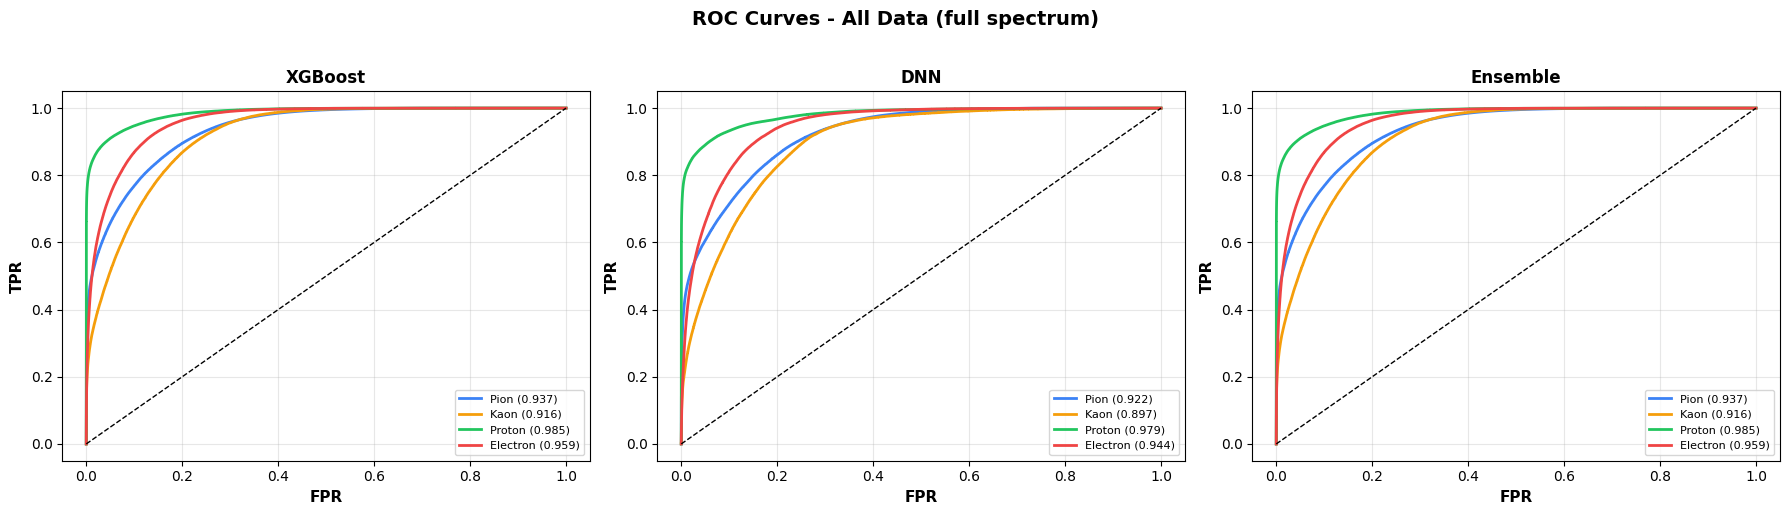

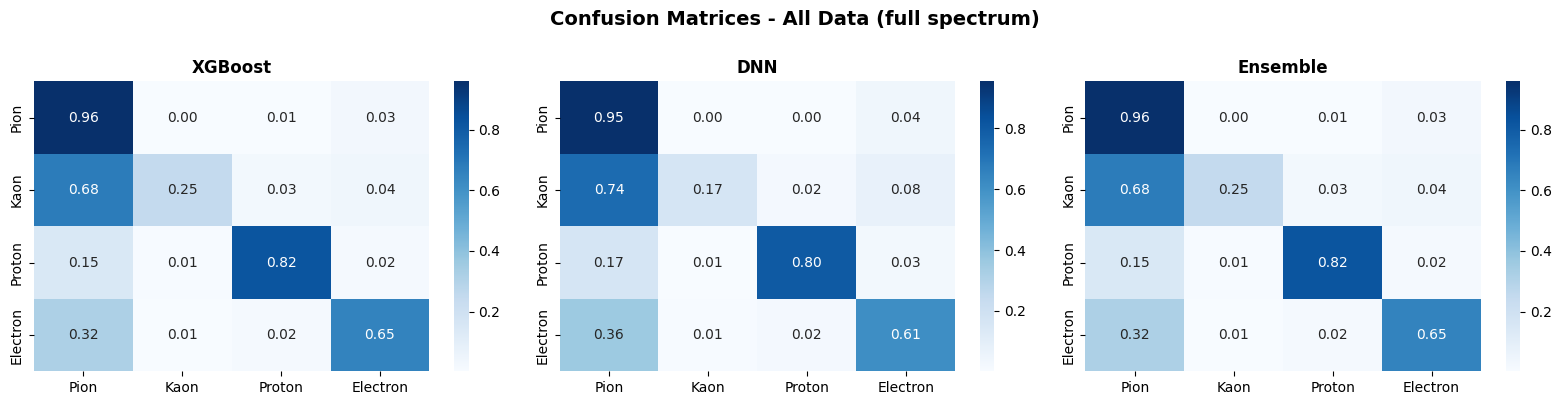

  Plots created

0.1-1 GeV/c


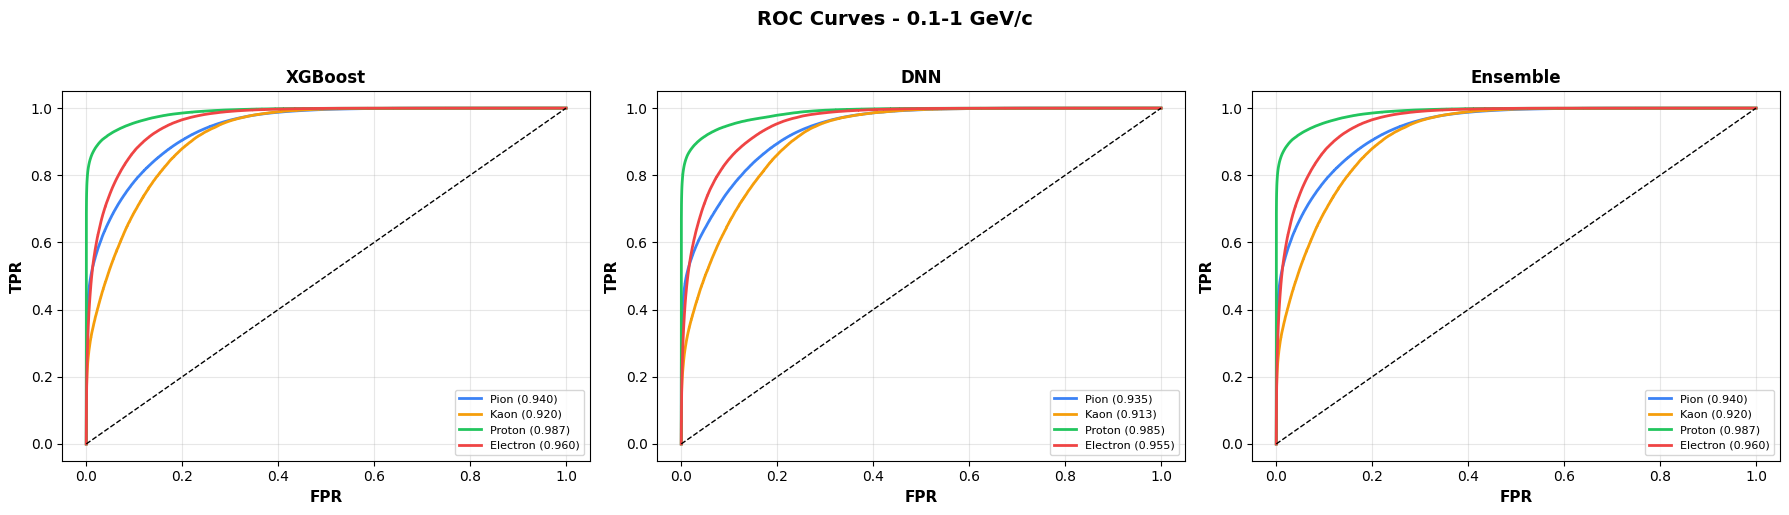

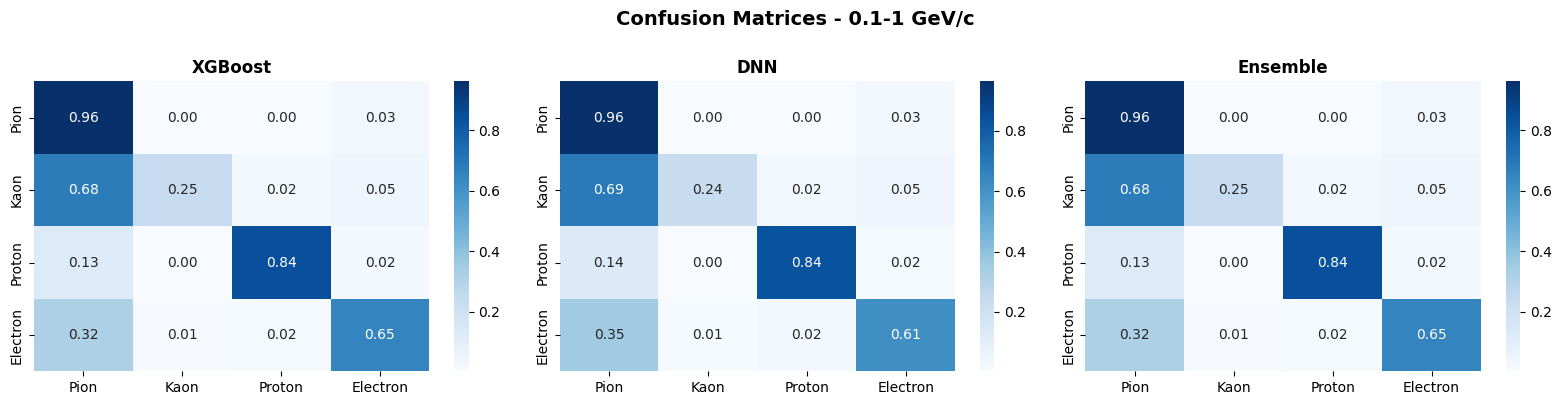

  Plots created

1-3 GeV/c


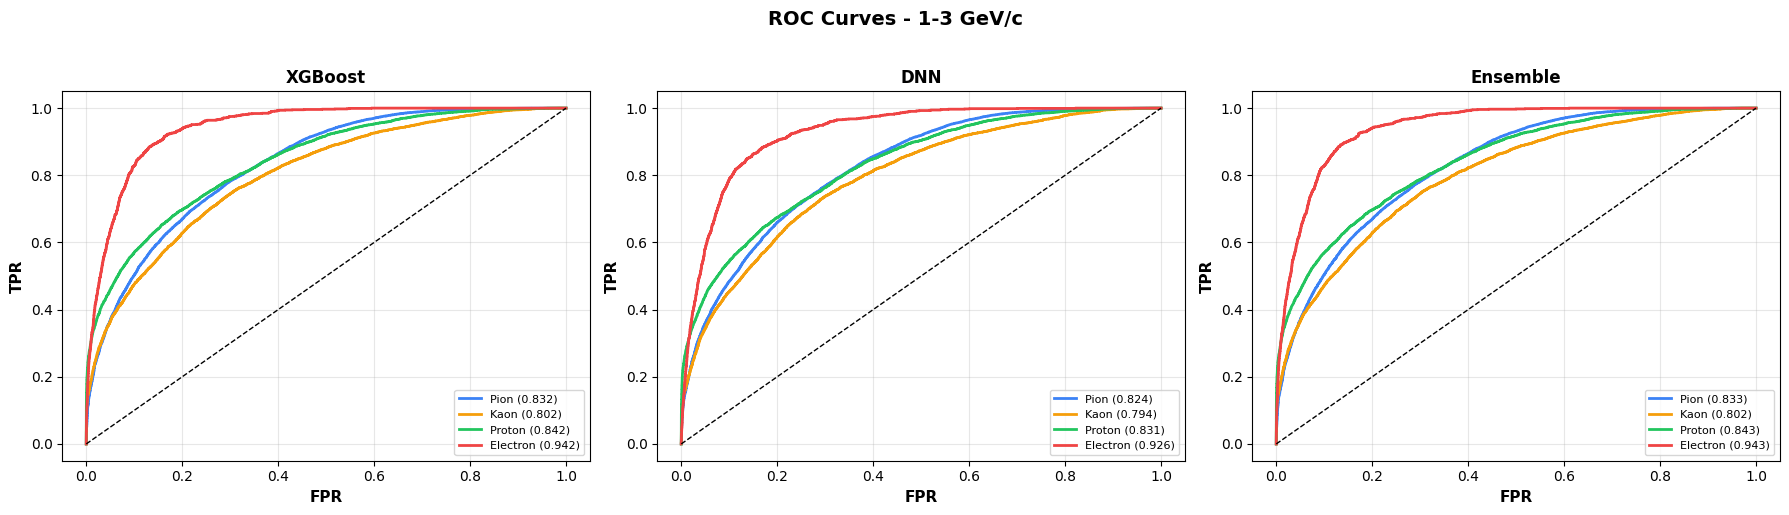

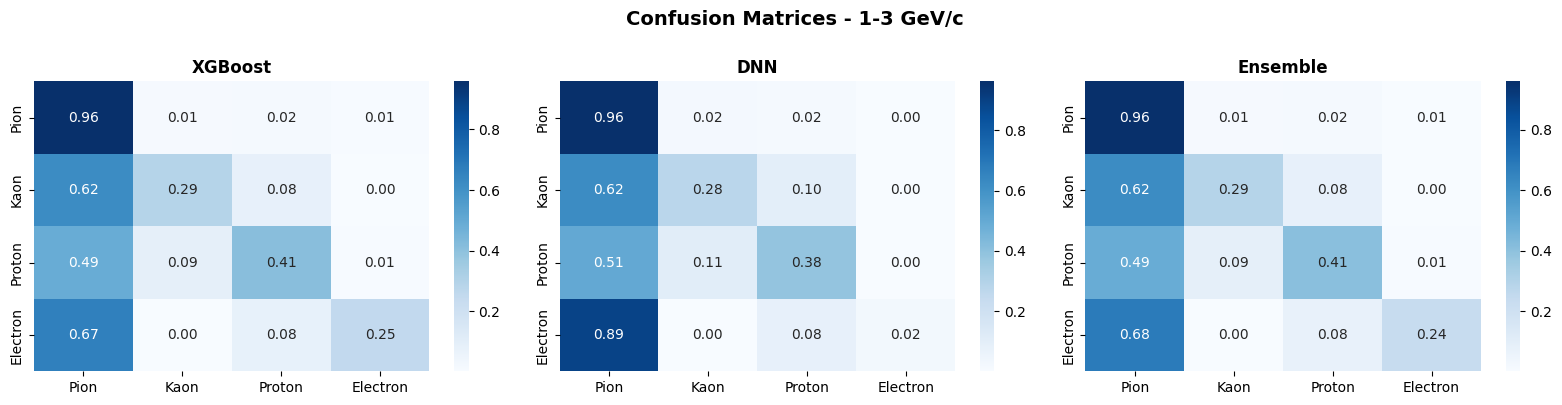

  Plots created

3+ GeV/c


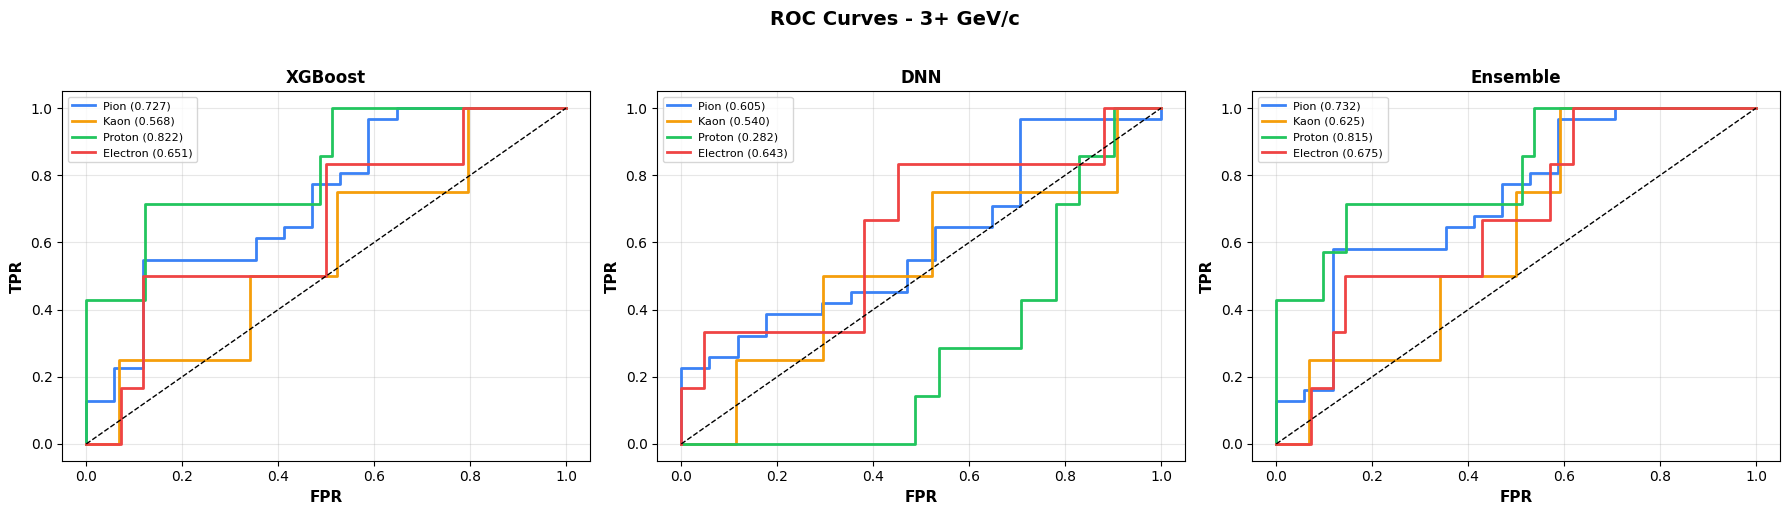

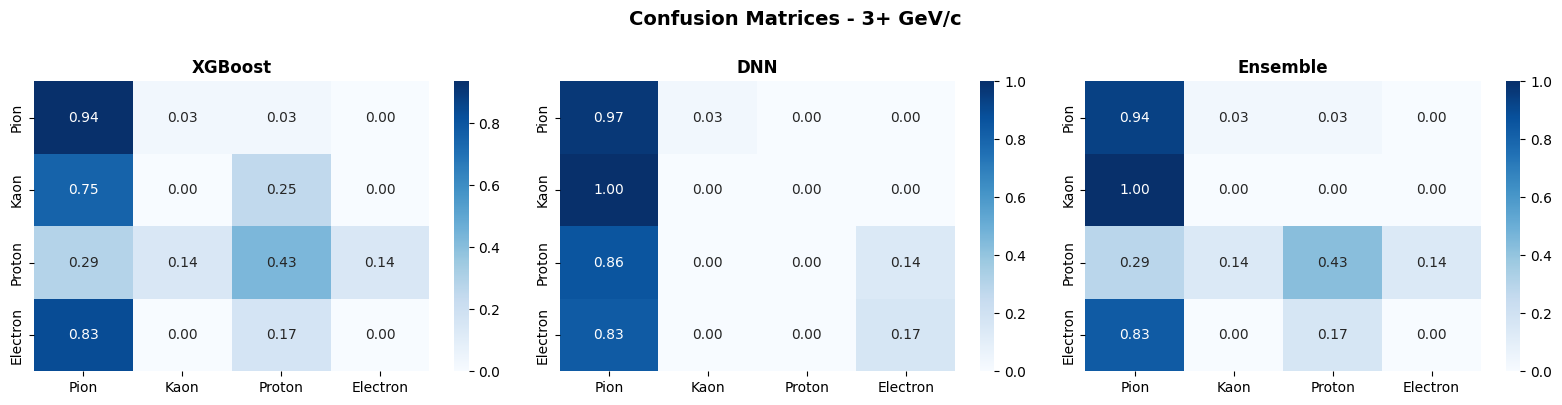

  Plots created

Visualisations complete


In [ ]:
print("\n" + "="*80)
print("SECTION 9: MODEL VISUALISATIONS")
print("="*80)

# Define colours for particles (one per particle type)
particle_colours = ['#3B82F6', '#F59E0B', '#22C55E', '#EF4444', '#8B5CF6']

for range_key in ['full', 'low', 'mid', 'high']:
    if range_key not in trained_xgb_models:
        continue

    range_name = momentum_datasets[range_key]['config']['name']
    print(f"\n{range_name}")

    y_test = momentum_datasets[range_key]['y_test'].values
    xgb_pred = trained_xgb_models[range_key]['y_pred_proba']
    dnn_pred = trained_dnn_models[range_key]['y_pred_proba']
    ensemble_pred = ensemble_models[range_key]['ensemble_pred']

    # ROC Curves Comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (pred, title) in enumerate([
        (xgb_pred, 'XGBoost'),
        (dnn_pred, 'DNN'),
        (ensemble_pred, 'Ensemble')
    ]):
        ax = axes[idx]
        for particle_idx in range(len(PARTICLE_NAMES)):
            if particle_idx < len(particle_colours):
                colour = particle_colours[particle_idx]
            else:
                colour = '#999999'

            y_bin = (y_test == particle_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, pred[:, particle_idx])
            from sklearn.metrics import auc as sklearn_auc
            roc_auc = sklearn_auc(fpr, tpr)
            ax.plot(fpr, tpr, color=colour, lw=2, label=f"{PARTICLE_NAMES[particle_idx]} ({roc_auc:.3f})")

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlabel('FPR', fontsize=11, fontweight='bold')
        ax.set_ylabel('TPR', fontsize=11, fontweight='bold')
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    plt.suptitle(f'ROC Curves - {range_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Confusion Matrices
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    for idx, (pred, title) in enumerate([(xgb_pred, 'XGBoost'), (dnn_pred, 'DNN'), (ensemble_pred, 'Ensemble')]):
        ax = axes[idx]
        y_pred_labels = np.argmax(pred, axis=1)
        cm = confusion_matrix(y_test, y_pred_labels, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                    xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES)
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')

    plt.suptitle(f'Confusion Matrices - {range_name}', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    print("  Plots created")

print("\nVisualisations complete")


## SECTION 10: Interactive Dashboard
### Compare Models Across Momentum Ranges

In [ ]:
print("\n" + "="*80)
print("SECTION 10: INTERACTIVE DASHBOARD")
print("="*80)

def compare_models(range_key):
    if range_key not in trained_xgb_models:
        return

    range_name = momentum_datasets[range_key]['config']['name']
    y_test = momentum_datasets[range_key]['y_test'].values

    xgb_acc = trained_xgb_models[range_key]['test_acc']
    dnn_acc = trained_dnn_models[range_key]['test_acc']
    ens_acc = ensemble_models[range_key]['ensemble_acc']

    models = ['XGBoost', 'DNN', 'Ensemble']
    accuracies = [xgb_acc, dnn_acc, ens_acc]
    colors = ['#3B82F6', '#F59E0B', '#22C55E']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.ylabel('Test Accuracy', fontsize=13, fontweight='bold')
    plt.title(f'Model Comparison - {range_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylim(0, max(accuracies) * 1.15)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Dashboard widgets
range_dd = widgets.Dropdown(
    options=list(momentum_datasets.keys()),
    value='full',
    description='Momentum Range:',
    style={'description_width': '150px'}
)

output = widgets.Output()

def update_dashboard(change=None):
    with output:
        clear_output(wait=True)
        compare_models(range_dd.value)

range_dd.observe(update_dashboard, names='value')

ui = widgets.VBox([
    widgets.HTML("<h3>🔀 Model Comparison Dashboard</h3>"),
    range_dd,
    output
])

with output:
    compare_models('full')

display(ui)
print("✓ Dashboard ready")


SECTION 10: INTERACTIVE DASHBOARD


✓ Dashboard ready


## SECTION 11: Final Summary
### Analysis Complete - Results Overview

In [ ]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print(f"\n✓ Models trained for {len(momentum_datasets)} momentum ranges:")
print(f"  • XGBoost models: {len(trained_xgb_models)}")
print(f"  • DNN models: {len(trained_dnn_models)}")
print(f"  • Ensemble models: {len(ensemble_models)}")

print(f"\n✓ Models saved to:")
print(f"  • XGBoost: {MODEL_SAVE_DIR}")
print(f"  • DNN: {DNN_SAVE_DIR}")
print(f"  • Optuna: {OPTUNA_SAVE_DIR}")

print(f"\n✓ Best Results Summary:")
for range_key in momentum_datasets.keys():
    if range_key in ensemble_models:
        range_name = momentum_datasets[range_key]['config']['name']
        ens_acc = ensemble_models[range_key]['ensemble_acc']
        xgb_w = ensemble_models[range_key]['xgb_weight']
        dnn_w = ensemble_models[range_key]['dnn_weight']
        print(f"\n  {range_name}:")
        print(f"    Ensemble Accuracy: {ens_acc:.4f}")
        print(f"    Weights: XGBoost={xgb_w:.2f}, DNN={dnn_w:.2f}")



ANALYSIS COMPLETE

✓ Models trained for 4 momentum ranges:
  • XGBoost models: 4
  • DNN models: 4
  • Ensemble models: 4

✓ Models saved to:
  • XGBoost: /content/drive/MyDrive/PID_Models/XGBoost/
  • DNN: /content/drive/MyDrive/PID_Models/DNN/
  • Optuna: /content/drive/MyDrive/PID_Models/Optuna_Studies/

✓ Best Results Summary:

  All Data (full spectrum):
    Ensemble Accuracy: 0.8675
    Weights: XGBoost=1.00, DNN=0.00

  0.1-1 GeV/c:
    Ensemble Accuracy: 0.8741
    Weights: XGBoost=1.00, DNN=0.00

  1-3 GeV/c:
    Ensemble Accuracy: 0.7470
    Weights: XGBoost=0.90, DNN=0.10

  3+ GeV/c:
    Ensemble Accuracy: 0.6667
    Weights: XGBoost=0.80, DNN=0.20
